# Import the libaraies

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
# Import to the current path
import os
os.chdir('/content/gdrive/MyDrive/dimension reduction')

In [ ]:
# Python ≥3.5 is required
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
import torch

# Common imports
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import time
from collections import deque

import joblib
import pandas as pd
import time
!pip install vtk -q
import vtktools, tools_io
from tools_io import get_nNodes_from_vtu, get_clean_vtu_file

In [ ]:
! pip install vtk -q
! pip install meshio -q
! pip install cmocean -q

loading in and preparing data

In [ ]:
# import latent variables and scalers
# change this files dir if you are in the different dirs
reduced_sfc = np.loadtxt('reduced_sfc.csv', delimiter=',') # scaled
scaler_std = joblib.load('output_files/scaler_std_full.pkl')
scaler_x = joblib.load('output_files/scaler_x_full.pkl')
scaler_y = joblib.load('output_files/scaler_y_full.pkl')
scaler_z = joblib.load('output_files/scaler_z_full.pkl')

autoencoder_py = joblib.load("models/autoencoder_py_43.pkl")
CO2data = joblib.load('CO2data.pkl')

In [ ]:
# function of reading the data of CO2_fluidity and CO2_Experiment
def ReadData(filename):
  output = []
  sf = open(filename, 'r')
  data = sf.readlines()
  for i in range(0,len(data)):
    x = str.split(data[i])
    y = [float(v) for v in x]
    output.append(y)

  #output = np.transpose(output)
  return output

In [ ]:
CO2_fluidity = ReadData('CO2_Fluidity.dat')
sensor_data = np.array(CO2_fluidity)
print(sensor_data.shape)
print('\t')
print(sensor_data[:,1:].shape) # no need first row(time levels)
sensor_data = sensor_data[:,1:]

(455, 8)
	
(455, 7)


In [ ]:
CO2_Experiment = ReadData('CO2_Experiment.dat')
Experiment_data = np.array(CO2_Experiment)
print(Experiment_data.shape)
print('\t')
print(Experiment_data[:,1:].shape) # no need first row(time levels)
Exp_time = Experiment_data[:,0]
Experiment_data = Experiment_data[:,1:]

(26, 8)
	
(26, 7)


# Scale the data

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler((-1,1))
scaler_reduced = MinMaxScaler((-1,1))

X_train_encode = scaler_minmax.fit_transform(reduced_sfc)
sensor_data_scale = scaler_reduced.fit_transform(sensor_data)
X_train_scaled = np.hstack((X_train_encode, sensor_data_scale))

In [ ]:
X_train_scaled = X_train_scaled.copy()
print(X_train_scaled.shape)
codings_size = X_train_scaled.shape[1] #50

(455, 50)


### Ensuring the enhanced data is scaled between [-1, 1]

POD coefficients and sensor data are scaled seperately but both [-1,1]

(array([10692.,   758.,   401.,   346.,   326.,   258.,   243.,   295.,
          443.,  8988.]),
 array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000000e-01,
        -2.00000000e-01,  2.22044605e-16,  2.00000000e-01,  4.00000000e-01,
         6.00000000e-01,  8.00000000e-01,  1.00000000e+00]),
 <a list of 10 Patch objects>)

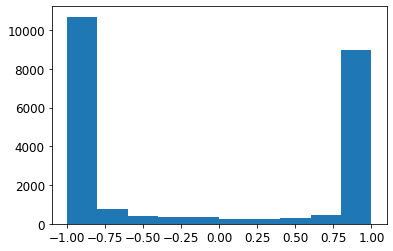

In [ ]:
# SFC-CAE latent variables
plt.hist(X_train_scaled.flatten())

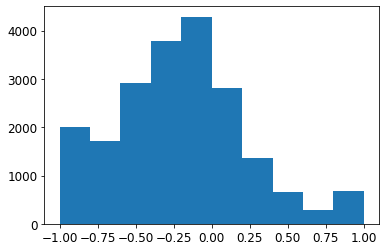

In [ ]:
# PCA latent variables
plt.hist(X_train_scaled.flatten())

The function `concat_timesteps(X_train, ntimes, step)` takes in a 2D array, picks 9 time levels at a time and skips time levels if needed.  

In [ ]:
def concat_timesteps(X_train, ntimes, step):
  X_train_concat = []
  for i in range(len(X_train) - ntimes*step):
      X_train_concat.append(X_train[i:i+ntimes*step:step])
  return np.array(X_train_concat) 

In [ ]:
ntimes = 9  # consecutive times for the GAN
step = 1 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step)
print("X_train_concat: ", np.shape(X_train_concat))
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )
print("X_train_concat_flatten: ", X_train_concat_flatten.shape)

X_train_4d = X_train_concat.reshape((X_train_concat.shape[0], ntimes, X_train_concat.shape[2], 1))  #(148706, 100, 81, 1)
print("X_train_4d: ", X_train_4d.shape)

#X_train_concat:  (401, 9, 50)
#X_train_concat_flatten:  (401, 450)
#X_train_4d:  (401, 9, 50, 1)

X_train_concat:  (446, 9, 50)
X_train_concat_flatten:  (446, 450)
X_train_4d:  (446, 9, 50, 1)


Loading model

In [ ]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model("gan-sfc-817-evening3-30000.h5").layers

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
npredict = 8
latent_space = 50
noise = tf.random.normal(shape=[npredict, latent_space])
pca_size = 43 # num of POD coefficients

Assimilate data with the GAN

In [ ]:
def pod_sse_loss(real_coding, gen_output):
    # -- POD coefficients --
    #
    # apply weights
    inp = tf.reshape(real_coding, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    out = tf.reshape(gen_output, [-1, codings_size])[:,:pca_size]*tf.math.sqrt(weight_pod)
    
    pod_loss = tf.reduce_sum(tf.math.squared_difference(inp, out))
    return pod_loss

def obs_sse_loss(real_coding, gen_output):
    # -- Observed sensor data --
    #
    # apply weights
    inp = tf.reshape(real_coding, [-1, codings_size])[:,pca_size:]*tf.math.sqrt(weight_obs)
    out = tf.reshape(gen_output, [-1, codings_size])[:,pca_size:]*tf.math.sqrt(weight_obs)
    
    obs_loss = tf.reduce_sum(tf.math.squared_difference(inp, out))
    return obs_loss

def optimize_coding_forward_onlyPOD(latent_values, real_coding, epochs=1000):

    optimizer = tf.keras.optimizers.Nadam(5e-3, 0.7, 0.999)
    
    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding):
      with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 

        pod_loss = pod_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])  
        obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])

        loss = pod_loss + obs_loss

      gradient = tape.gradient(loss, latent_values)  
      optimizer.apply_gradients(zip([gradient], [latent_values]))  

      return loss, pod_loss, obs_loss  
    
    loss = []
    for epoch in range(epochs):
      loss.append(opt_step_forward(optimizer, latent_values, real_coding))
         
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output

def optimize_coding_LastForward(latent_values, real_coding, epochs=1000):

    optimizer = tf.keras.optimizers.Nadam(2e-3, 0.9, 0.999)

    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding):
      with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 

        pod_loss = pod_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])  
        obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])

        loss = pod_loss

      gradient = tape.gradient(loss, latent_values)  
      optimizer.apply_gradients(zip([gradient], [latent_values]))  

      return loss, pod_loss, obs_loss  
    
    loss = []
    for epoch in range(epochs):
      loss.append(opt_step_forward(optimizer, latent_values, real_coding))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


def optimize_coding_forward(latent_values, real_coding, epochs=1000):

    optimizer = tf.keras.optimizers.Nadam(2e-3, 0.9, 0.999)
    
    @tf.function
    def opt_step_forward(optimizer, latent_values, real_coding):
      with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 

        pod_loss = pod_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
        obs_loss = obs_sse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   
        loss = pod_loss + obs_loss 

      gradient = tape.gradient(loss, latent_values)  
      optimizer.apply_gradients(zip([gradient], [latent_values]))  

      return loss, pod_loss, obs_loss
    
    loss = []
    for epoch in range(epochs):
      loss.append(opt_step_forward(optimizer, latent_values, real_coding))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output


def optimize_coding_backward(latent_values, real_coding, epochs=1000):
    
    optimizer = tf.keras.optimizers.Nadam(2e-3, 0.9, 0.999)
    
    @tf.function
    # def opt_step_backward(optimizer, latent_values, real_coding, obs_data):
    def opt_step_backward(optimizer, latent_values, real_coding):
      with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 
        pod_loss = pod_sse_loss(real_coding, gen_output[:,1:,:,:])   
        obs_loss = obs_sse_loss(real_coding, gen_output[:,1:,:,:])   
        loss = pod_loss + obs_loss 

      gradient = tape.gradient(loss, latent_values)  
      optimizer.apply_gradients(zip([gradient], [latent_values]))  

      return loss, pod_loss, obs_loss 
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step_backward(optimizer, latent_values, real_coding))
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output

In [ ]:
forward_steps = 447 #101 #15 #10
time_steps = forward_steps + (ntimes-1)
# # peripheral/surrounding nodes of sensor location
# locs = [10492, 87417, 126524, 117412, 68542, 25412, 38425, 84453]

In [ ]:
# modify this to fit the weight of SFC-CAE latent representation
# Delta variables 
delta_obs = 120
delta_pod = 2

# POD coefficients
#weight_pod = 0.005*pca.singular_values_/pca.singular_values_.sum() # PCA case
weight_pod = 0.00005*np.ones(43)
weight_pod = tf.constant(weight_pod, dtype=tf.float32)

print('weight_pod: ', weight_pod, end='\n\n')

# Observed data
weight_obs = 0.5*((delta_pod/delta_obs)**2)*ntimes #increase this value

print('weight_obs', weight_obs, end='\n\n')

weight_pod:  tf.Tensor(
[0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005
 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005
 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005
 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005
 0.0005 0.0005 0.0005], shape=(43,), dtype=float32)

weight_obs 0.00125



Run data assimilation

流式输出内容被截断，只能显示最后 5000 行内容。
Loss iteration 421: ['7.86e-04', '4.18e-04', '3.68e-04'] - 1s
Loss iteration 422: ['7.33e-04', '3.88e-04', '3.45e-04'] - 1s
Loss iteration 423: ['6.98e-04', '3.72e-04', '3.26e-04'] - 1s
Loss iteration 424: ['6.76e-04', '3.65e-04', '3.11e-04'] - 1s
Loss iteration 425: ['6.65e-04', '3.65e-04', '3.00e-04'] - 1s
Loss iteration 426: ['6.58e-04', '3.66e-04', '2.91e-04'] - 1s
Loss iteration 427: ['6.54e-04', '3.66e-04', '2.88e-04'] - 1s
Loss iteration 428: ['6.50e-04', '3.65e-04', '2.86e-04'] - 1s
Loss iteration 429: ['6.50e-04', '3.63e-04', '2.86e-04'] - 1s
Loss iteration 430: ['6.59e-04', '3.74e-04', '2.85e-04'] - 1s
Loss iteration 431: ['6.90e-04', '4.09e-04', '2.81e-04'] - 1s
Loss iteration 432: ['7.55e-04', '4.83e-04', '2.72e-04'] - 1s
Loss iteration 433: ['8.85e-04', '6.12e-04', '2.73e-04'] - 1s
Loss iteration 434: ['1.12e-03', '8.27e-04', '2.93e-04'] - 1s
Loss iteration 435: ['1.45e-03', '1.10e-03', '3.53e-04'] - 1s
Loss iteration 436: ['1.58e-03', '1.19e-03'

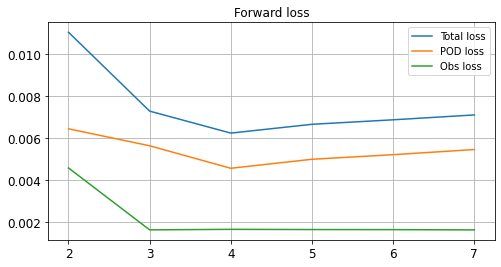

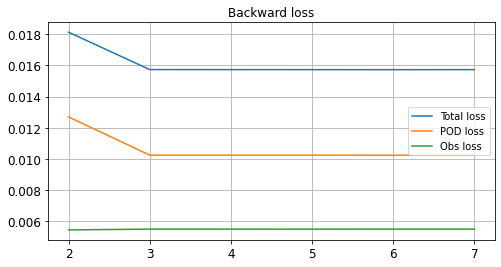

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

list_X_predict_forward = []
list_X_predict_backward = []
list_relax = []

# Forward and backward march   
forward_loss = []
backward_loss = []
forward_onlyPOD_loss = []
relax = 1.0
alltimes = 447
for j in range(10):    
    print(f'\nIteration {j}: forward and backward')
    latent_values_forward = []
    latent_values_backward = []
    
    #===========================================
    # Forward march 
    #===========================================
    print('-- Forward March --')
    
    loss_iteration = []
    
    if j == 0: # If the first forward march
        # For the first forward march
        n = 0

        real_coding = X_train_concat[n]#.reshape(1,-1)
        real_coding = real_coding[:-1,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        
        list_latent_values = []
        list_loss = []
        for _ in range(10):
            latent_values = tf.random.normal([1, latent_space], mean=0.0, stddev=0.01)  
            latent_values = tf.Variable(latent_values) 
            latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, epochs=5000)#5000
            list_latent_values.append(latent_values)
            list_loss.append(loss)
        latent_values = list_latent_values[np.argmin(list_loss,axis=0)[0]]
        loss_iteration.append(list(map(float,list_loss[np.argmin(list_loss,axis=0)[0]])))
        print('Initial point losses: ', end='\n')
        for l in list_loss:
            print(['{0:1.2e}'.format(float(x)) for x in l])
        print()
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in list_loss[np.argmin(list_loss,axis=0)[0]]]), end='\n')        

        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        gen_predict = X_predict_forward[-1]
        #gen_predict[-7:] = obs_run  
    
    else: # If not the first forward march
        real_coding = X_predict_backward[0:(ntimes-1),:].copy()
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)  
        
        latent_values, loss = optimize_coding_forward(latent_values, real_coding, epochs=100)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[0] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')
    
        latent_values_forward.append(latent_values.value())
        X_predict_forward = list(generator(latent_values).numpy().reshape(-1,codings_size))
        gen_predict = X_predict_forward[-1]

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print(real_coding.shape)
    for i in range(1, forward_steps): 
        if i >= 403:
            real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
            real_coding = tf.constant(real_coding)
            real_coding = tf.cast(real_coding, dtype=tf.float32)
        else:
            real_coding = np.concatenate([real_coding[:, :pca_size], X_train_scaled[i:(ntimes-1+i), pca_size:]], axis=1)
            real_coding = tf.constant(real_coding)
            real_coding = tf.cast(real_coding, dtype=tf.float32)
        
        start = time.time()
        if j == 0:    
            latent_values, loss = optimize_coding_forward_onlyPOD(latent_values, real_coding, epochs=100)
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())   
        
        else:
            latent_values, loss = optimize_coding_forward(latent_values, real_coding, epochs=100)
            latent_values = tf.Variable((1-relax)*latent_values_forward_old[i] + relax*latent_values.value())
        
            loss_iteration.append(list(map(float,loss)))
            print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

            latent_values_forward.append(latent_values.value())
            gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[-1]
            X_predict_forward.append(gen_predict.copy())

        real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_forward = np.array(X_predict_forward)
    if j == 0:
        X_predict_forward_first = X_predict_forward
    forward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])
        

    #===========================================
    # Backward march
    #===========================================
    print('-- Backward March --')

    loss_iteration = []
    
    real_coding = X_predict_forward[time_steps-(ntimes-1):time_steps,:].copy()
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    latent_values, loss = optimize_coding_backward(latent_values, real_coding, epochs=100)
    if j != 0:
        latent_values = tf.Variable((1-relax)*latent_values_backward_old[0] + relax*latent_values.value())
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

    latent_values_backward.append(latent_values.value())
    X_predict_backward = deque(generator(latent_values).numpy().reshape(-1,codings_size))
    gen_predict = X_predict_backward[0]

    real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    
    for i in range(1, forward_steps): 

        if time_steps-(ntimes-1) - i >= 403:
            real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
            real_coding = tf.constant(real_coding)
            real_coding = tf.cast(real_coding, dtype=tf.float32)
        else:
            real_coding = np.concatenate([real_coding[:, :pca_size], X_train_scaled[time_steps-(ntimes-1) - i : (time_steps - i), pca_size:]], axis=1)      
            real_coding = tf.constant(real_coding)
            real_coding = tf.cast(real_coding, dtype=tf.float32)

        start = time.time()

        latent_values, loss = optimize_coding_backward(latent_values, real_coding, epochs=100)
        if j != 0:
            latent_values = tf.Variable((1-relax)*latent_values_backward_old[i] + relax*latent_values.value())
        loss_iteration.append(list(map(float,loss)))
        print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

        latent_values_backward.append(latent_values.value())
        gen_predict = generator(latent_values).numpy().reshape(-1,codings_size)[0]
        X_predict_backward.appendleft(gen_predict.copy())

        real_coding = np.concatenate((gen_predict.reshape(1,-1), real_coding), axis=0)[:-1,:]
        real_coding = tf.constant(real_coding)
        real_coding = tf.cast(real_coding, dtype=tf.float32)
        print ('{:.0f}s'.format( time.time()-start))
    X_predict_backward = np.array(X_predict_backward)
    backward_loss.append(np.array(loss_iteration).mean(axis=0))
    print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])
    
    # Save relaxation
    list_relax.append(relax)

    # Update relaxation
    epsilon = 0.98
    loss_obs = (forward_loss[-1][-1] + backward_loss[-1][-1])/2 
    print(f'Loss obs: {loss_obs}')
    if j == 0:
        loss_obs_old = loss_obs        
        latent_values_forward_old = latent_values_forward.copy()
        latent_values_backward_old = latent_values_backward.copy()
        X_predict_backward_old = X_predict_backward.copy()
        # weight_R0_old = tf.identity(weight_R0)
    else:
        print(f'Loss obs old: {loss_obs_old}')
        print(f'Relax old: {relax}, new ', end='')
        if (loss_obs - loss_obs_old*epsilon) < 0:
            loss_obs_old = loss_obs
            X_predict_backward_old = X_predict_backward.copy()
            latent_values_forward_old = latent_values_forward.copy()
            latent_values_backward_old = latent_values_backward.copy()
            # weight_R0_old = tf.identity(weight_R0)
            relax *= 1.5
            if relax > 1.0: 
                relax = 1.0              
        else:
            relax *= 0.5
            if relax < 0.05: 
                print(relax)
                print('Converged!')
                # plot loss functions
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(forward_loss)), forward_loss[2:])
                ax.set_title('Forward loss')
                #ax.set_yscale('log')
                #ax.set_ylim([0,20000])
                plt.grid()
                plt.legend(['Total loss','POD loss','Obs loss'])    
                fig, ax = plt.subplots(1,1, figsize=[8,4])
                ax.plot(np.arange(2,len(backward_loss)), backward_loss[2:])
                #ax.set_yscale('log')
                ax.set_title('Backward loss')
                #ax.set_ylim([0,20000])
                plt.grid()
                plt.legend(['Total loss','POD loss','Obs loss'])
                break
            X_predict_backward = X_predict_backward_old
            latent_values_forward = latent_values_forward_old
            latent_values_backward = latent_values_backward_old
            # weight_R0.assign(weight_R0_old)
        print(relax) 
    
    list_X_predict_forward.append(X_predict_forward)
    list_X_predict_backward.append(X_predict_backward)
    

In [ ]:
#===========================================
# Last time stepping forward march
#===========================================
print('-- Last time Stepping Forward March --')

loss_iteration = []

real_coding = X_predict_backward[0:(ntimes-1),:].copy()
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)  

latent_values_onlyPOD = tf.Variable(latent_values)
latent_values_onlyPOD, loss = optimize_coding_forward_onlyPOD(latent_values_onlyPOD, real_coding, epochs=100)
loss_iteration.append(list(map(float,loss)))
print('Loss iteration 0: '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end='\n')

X_predict_forward_last = list(generator(latent_values_onlyPOD).numpy().reshape(-1,codings_size))
gen_predict = X_predict_forward_last[-1]
#gen_predict[-7:] = obs_run

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:] #?? should it be -> [codings_size:, :]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(1, forward_steps): 

    start = time.time()
    latent_values_onlyPOD, loss = optimize_coding_forward_onlyPOD(latent_values_onlyPOD, real_coding, epochs=100)
    
    loss_iteration.append(list(map(float,loss)))
    print('Loss iteration '+str(i)+': '+str(['{0:1.2e}'.format(float(x)) for x in loss]), end=' - ')

    gen_predict = generator(latent_values_onlyPOD).numpy().reshape(-1,codings_size)[-1]
    X_predict_forward_last.append(gen_predict.copy())

    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=0)[1:,:] #?? same query as above?
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
X_predict_forward_last = np.array(X_predict_forward_last)
forward_onlyPOD_loss.append(np.array(loss_iteration).mean(axis=0))
print('Loss iteration mean:', ['{0:1.2e}'.format(float(x)) for x in np.array(loss_iteration).mean(axis=0)])


-- Last time Stepping Forward March --
Loss iteration 0: ['1.22e-02', '9.93e-03', '2.23e-03']
Loss iteration 1: ['1.02e-02', '8.47e-03', '1.71e-03'] - 1s
Loss iteration 2: ['8.17e-03', '6.86e-03', '1.32e-03'] - 1s
Loss iteration 3: ['7.10e-03', '5.95e-03', '1.14e-03'] - 1s
Loss iteration 4: ['6.65e-03', '5.46e-03', '1.19e-03'] - 1s
Loss iteration 5: ['7.55e-03', '6.16e-03', '1.39e-03'] - 1s
Loss iteration 6: ['8.93e-03', '7.29e-03', '1.64e-03'] - 1s
Loss iteration 7: ['1.11e-02', '9.06e-03', '2.08e-03'] - 1s
Loss iteration 8: ['1.36e-02', '1.12e-02', '2.38e-03'] - 1s
Loss iteration 9: ['1.35e-02', '1.12e-02', '2.31e-03'] - 1s
Loss iteration 10: ['1.35e-02', '1.12e-02', '2.26e-03'] - 1s
Loss iteration 11: ['1.36e-02', '1.14e-02', '2.23e-03'] - 1s
Loss iteration 12: ['1.39e-02', '1.17e-02', '2.21e-03'] - 1s
Loss iteration 13: ['1.45e-02', '1.23e-02', '2.20e-03'] - 1s
Loss iteration 14: ['1.54e-02', '1.32e-02', '2.21e-03'] - 1s
Loss iteration 15: ['1.70e-02', '1.48e-02', '2.21e-03'] - 1s


0 [0.00984154 0.005347   0.00449454]
1 [0.01072328 0.00707673 0.00364655]
2 [0.01072328 0.00707673 0.00364655]
3 [0.01151839 0.00794794 0.00357045]
4 [0.01151839 0.00794794 0.00357045]
5 [0.01151839 0.00794794 0.00357045]
6 [0.01151839 0.00794794 0.00357045]
7 [0.01142647 0.00785699 0.00356948]


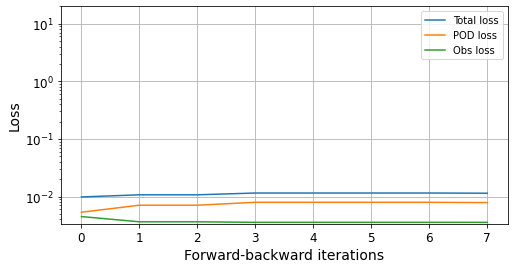

In [ ]:
loss = (np.array(backward_loss)+np.array(forward_loss))/2
new_loss = loss.copy()

# discard the forward-backward iteration with loss greater than the minimum
print(0, new_loss[0,:])
for i in range(1,len(new_loss)):
    if new_loss[i,-1] > new_loss[i-1,-1]:
        new_loss[i,:] = new_loss[i-1,:] 
    print(i, new_loss[i,:])
    
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(new_loss)
ax.set_yscale('log')
ax.set_ylim(top=2*10**1)
ax.set_ylabel('Loss') 
ax.set_xlabel('Forward-backward iterations')   
plt.grid()
plt.legend(['Total loss','POD loss','Obs loss'])

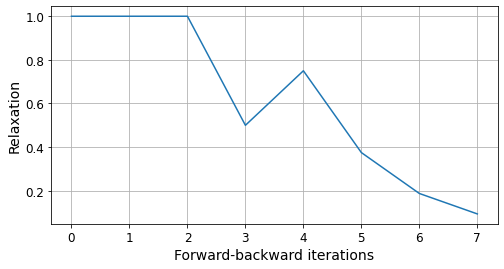

In [ ]:
fig, ax = plt.subplots(1,1, figsize=[8,4])
ax.plot(list_relax)
ax.set_ylabel('Relaxation') 
ax.set_xlabel('Forward-backward iterations')  
plt.grid()

# Reconstructions

First forward pass

In [ ]:
import torch
import h5py
#split_inv = np.split(X_predict_forward_first, [43, ], axis=1)
#alpha = split_inv[0]
#print(alpha.shape)
#sensor_CO2 = split_inv[-1]

#np.savetxt('alpha.csv', alpha, delimiter=',')
#np.savetxt('sensor_co2.csv', sensor_CO2, delimiter=',')

# save the alpha for analysis
alpha = np.loadtxt('alpha.csv', delimiter=',')
sensor_CO2 = np.loadtxt('sensor_co2.csv', delimiter=',')
print(alpha.shape)
print(sensor_CO2.shape)

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)

#undoing scaling
alpha_unscaled = scaler_minmax.inverse_transform(alpha)
print('alpha_unscaled: ',alpha_unscaled.shape, alpha_unscaled.dtype)

#******************************* h5 *******************************#
f=h5py.File("alpha_unscaled.hdf5","w")
d1=f.create_dataset("dset1", data = alpha_unscaled)
f.close()

# load this when load the h5 data that is put into decoder
f=h5py.File("alpha_unscaled.hdf5","r")
print(list(f.keys()))

dset = f['dset1'] # dtype('<f8')

print('dset dtype: ',dset.dtype)
#******************************* h5 *******************************#

# load data into h5 file in order to reduce the load of RAM when dealing with large array
alpha_unscaled_tensor = torch.tensor(dset)
X_recovered = autoencoder_py.decoder.to('cpu')(alpha_unscaled_tensor.float())

print('-- finish X_recovered --')
X_recovered = X_recovered.detach().numpy()
print(X_recovered[:,:,1].shape)

norm_co2_ = scaler_std.inverse_transform(X_recovered[:,:,0])
norm_x_ = scaler_x.inverse_transform(X_recovered[:,:,1])
norm_y_ = scaler_y.inverse_transform(X_recovered[:,:,2])
norm_z_ = scaler_z.inverse_transform(X_recovered[:,:,3])
norm_sensor_CO2_ = scaler_reduced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_.shape)
print("norm_z_ shape: ", norm_z_.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_.shape)
f.close()

(455, 43)
(455, 7)
GAN shape output of sensor CO2:  (455, 7)
alpha_unscaled:  (455, 43) float64
['dset1']
dset dtype:  float64
-- finish X_recovered --
(455, 148906)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


In [ ]:
reduced_sfc = np.loadtxt('reduced_sfc.csv', delimiter=',') # scaled
print('shape of reduced_sfc: ',reduced_sfc.shape)
reduced_sfc_tensor = torch.tensor(reduced_sfc)

#******************************* h5 *******************************#
f=h5py.File("reduced_sfc_tensor.hdf5","w")
d1=f.create_dataset("dset1", data = reduced_sfc_tensor)
f.close()

# load this when load the h5 data that is put into decoder
f=h5py.File("reduced_sfc_tensor.hdf5","r")
print(list(f.keys()))

dset = f['dset1'] # dtype('<f8')

print('dset dtype: ',dset.dtype)
#******************************* h5 *******************************#


X_recovered = autoencoder_py.decoder.to('cpu')(reduced_sfc_tensor.float())

X_recovered = X_recovered.detach().numpy()
real_co2_ = scaler_std.inverse_transform(X_recovered[:,:,0])
real_x_ = scaler_x.inverse_transform(X_recovered[:,:,1])
real_y_ = scaler_y.inverse_transform(X_recovered[:,:,2])
real_z_ = scaler_z.inverse_transform(X_recovered[:,:,3])

shape of reduced_sfc:  (455, 43)
['dset1']
dset dtype:  float64


In [ ]:
#split_inv = np.split(X_predict_forward_last, [43, ], axis=1)
#alpha = split_inv[0]
#print(alpha.shape)
#sensor_CO2 = split_inv[-1]

#np.savetxt('alpha_da.csv', alpha, delimiter=',')
#np.savetxt('sensor_co2_da.csv', sensor_CO2, delimiter=',')

alpha = np.loadtxt('alpha_da.csv', delimiter=',')
sensor_CO2 = np.loadtxt('sensor_co2_da.csv', delimiter=',')

print(alpha.shape)

print("GAN shape output of sensor CO2: ", sensor_CO2.shape)

#undoing pca scaling
alpha_unscaled_DA = scaler_minmax.inverse_transform(alpha)
print(alpha_unscaled.shape)
alpha_unscaled_tensor_DA = torch.tensor(alpha_unscaled_DA)

#******************************* h5 *******************************#
f=h5py.File("alpha_unscaled_tensor_DA.hdf5","w")
d1=f.create_dataset("dset1", data = alpha_unscaled_tensor_DA)
f.close()

# load this when load the h5 data that is put into decoder
f=h5py.File("alpha_unscaled_tensor_DA.hdf5","r")
print(list(f.keys()))

dset = f['dset1'] # dtype('<f8')

print('dset dtype: ',dset.dtype)
#******************************* h5 *******************************#

X_recovered_tensor = autoencoder_py.decoder.to('cpu')(alpha_unscaled_tensor_DA.float())
X_recovered_DA = X_recovered_tensor.detach().numpy()

print("X_recovered shape: ", X_recovered_DA.shape)

norm_co2_DA = scaler_std.inverse_transform(X_recovered_DA[:,:,0])
norm_x_DA = scaler_x.inverse_transform(X_recovered_DA[:,:,1])
norm_y_DA = scaler_y.inverse_transform(X_recovered_DA[:,:,2])
norm_z_DA = scaler_z.inverse_transform(X_recovered_DA[:,:,3])
norm_sensor_CO2_DA = scaler_reduced.inverse_transform(sensor_CO2)

print("norm_co2_ shape: ", norm_co2_DA.shape)
print("norm_z_ shape: ", norm_z_DA.shape)
print("norm_sensor_CO2_ shape: ", norm_sensor_CO2_DA.shape)

(455, 43)
GAN shape output of sensor CO2:  (455, 7)
(455, 43)
['dset1']
dset dtype:  float64
X_recovered shape:  (455, 148906, 4)
norm_co2_ shape:  (455, 148906)
norm_z_ shape:  (455, 148906)
norm_sensor_CO2_ shape:  (455, 7)


In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
# 8 nodes -> 0, 100, 200, 300 ...
for i in range(8):
    ax.flatten()[i].plot(norm_co2_[:455,i*200], '-')
    ax.flatten()[i].plot(real_co2_[:455,i*200], '-')
    
    ax.flatten()[i].legend(['prediction', 'real'])

# Start to plot

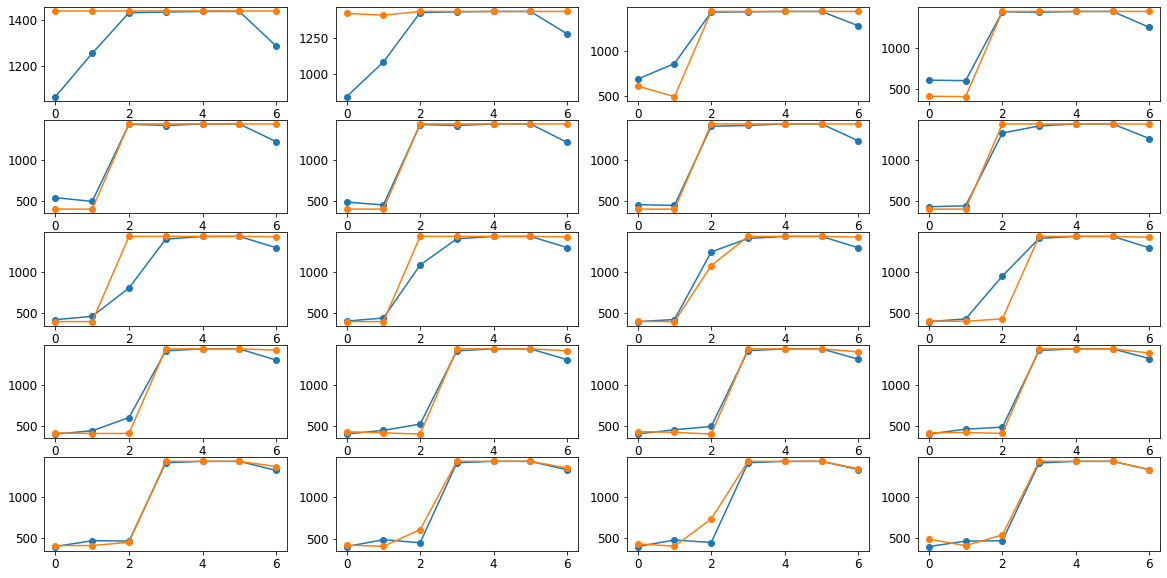

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
  ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
  ax.flatten()[i].plot(sensor_data[i,:], '-o')

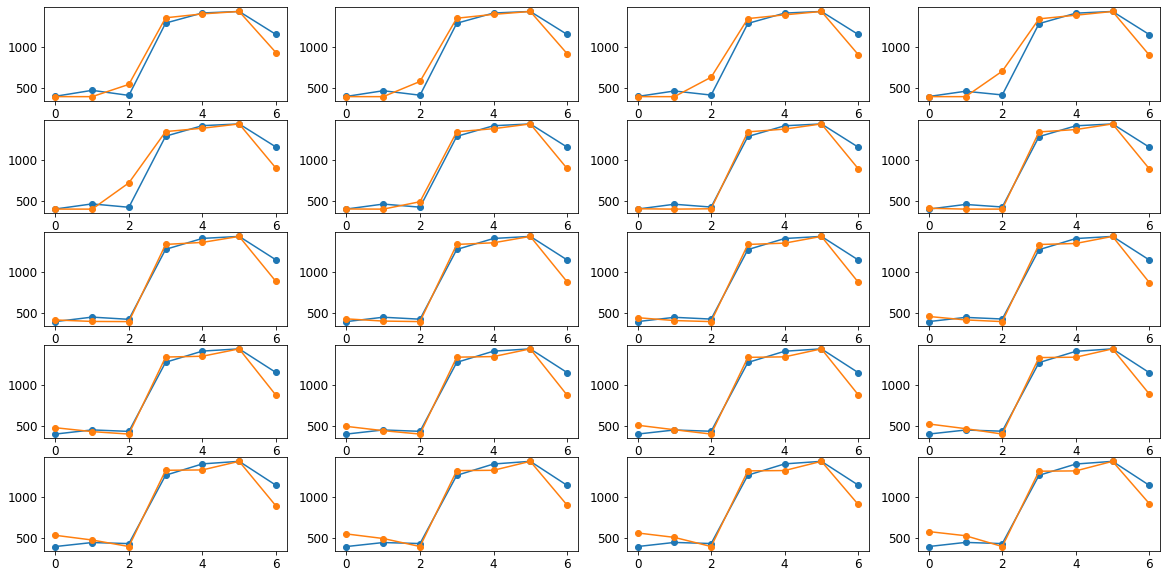

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[80+i,:], '-o')
    ax.flatten()[i].plot(sensor_data[80+i,:], '-o')

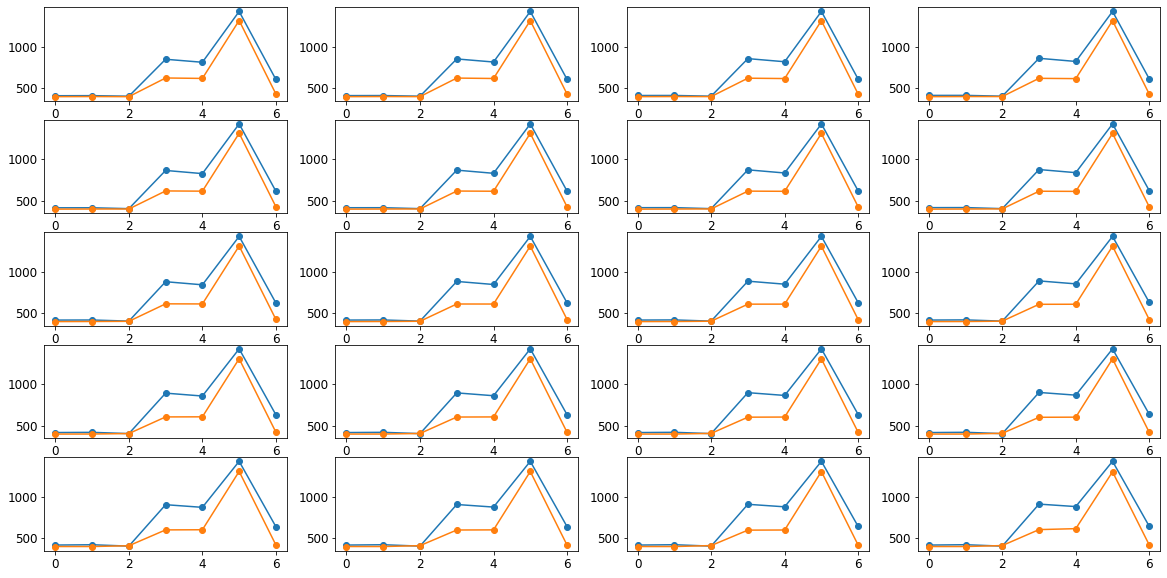

In [ ]:
fig, ax = plt.subplots(5,4, figsize=[20,10])
for i in range(20):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(sensor_data[435+i,:], '-o')

DA pass with Last

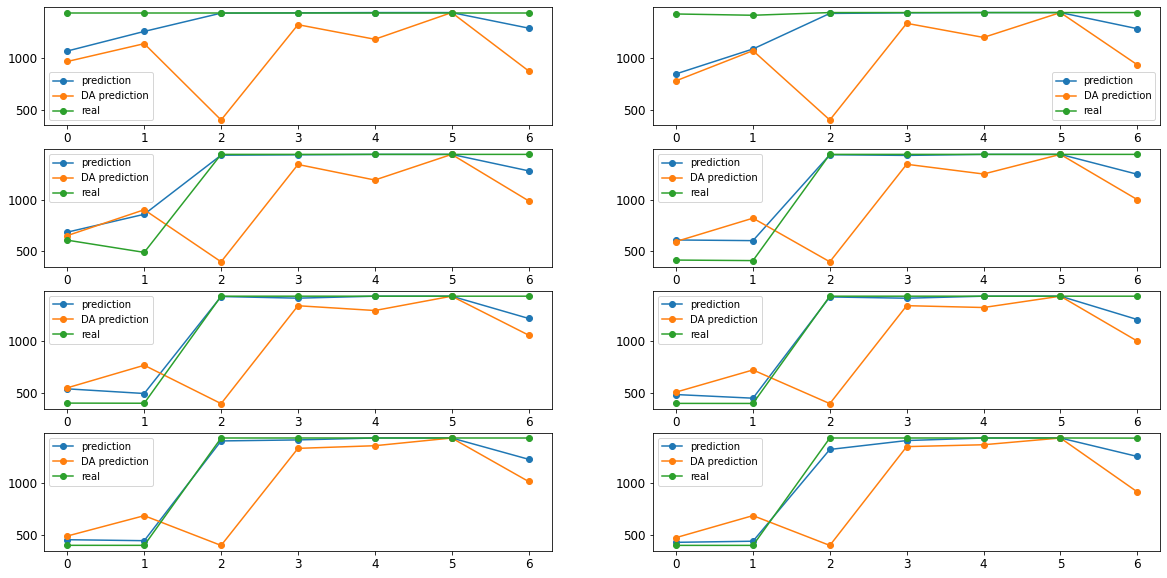

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[i,:], '-o')
    ax.flatten()[i].plot(sensor_data[i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])

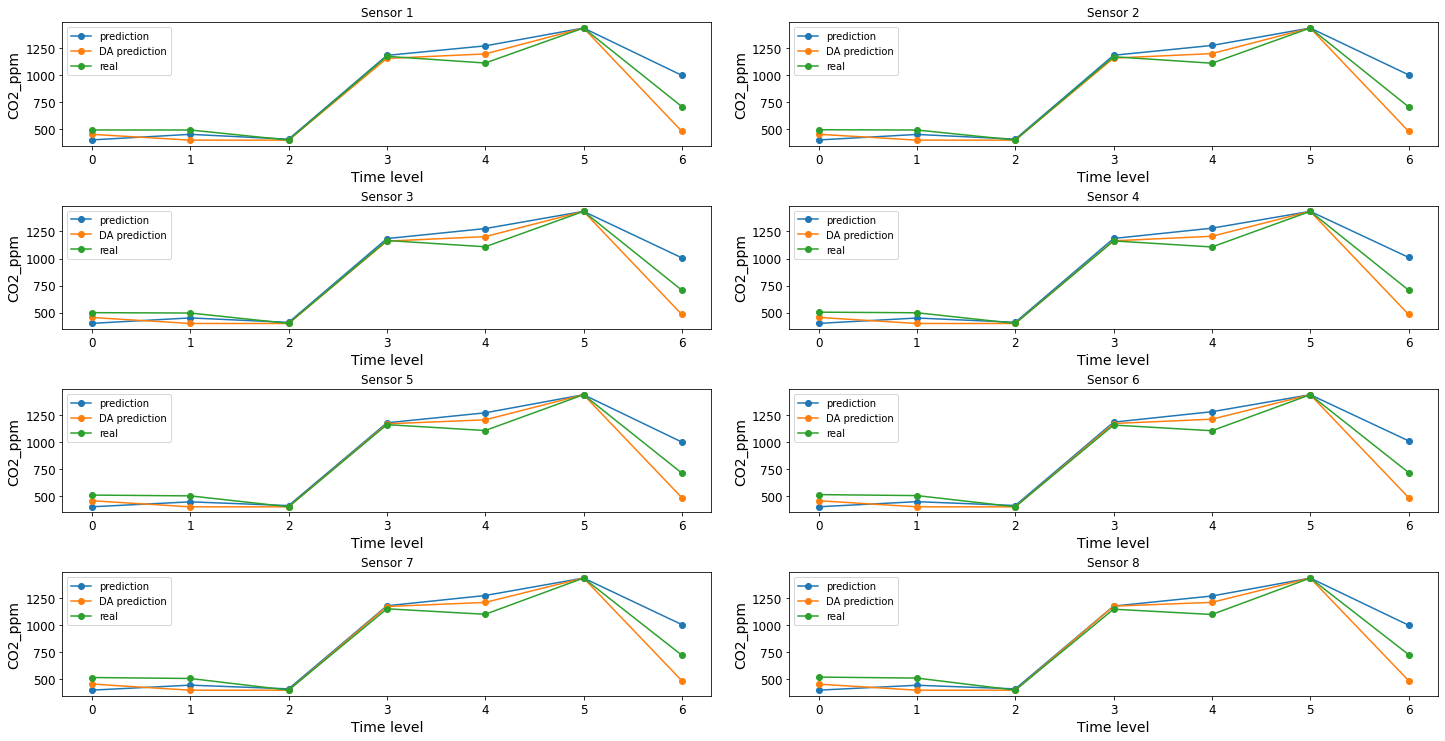

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[150+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[150+i,:], '-o')
    ax.flatten()[i].plot(sensor_data[150+i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])
    ax.flatten()[i].set_title('Sensor '+ str(i+1))
    ax.flatten()[i].set_xlabel('Time level')
    ax.flatten()[i].set_ylabel('CO2_ppm')

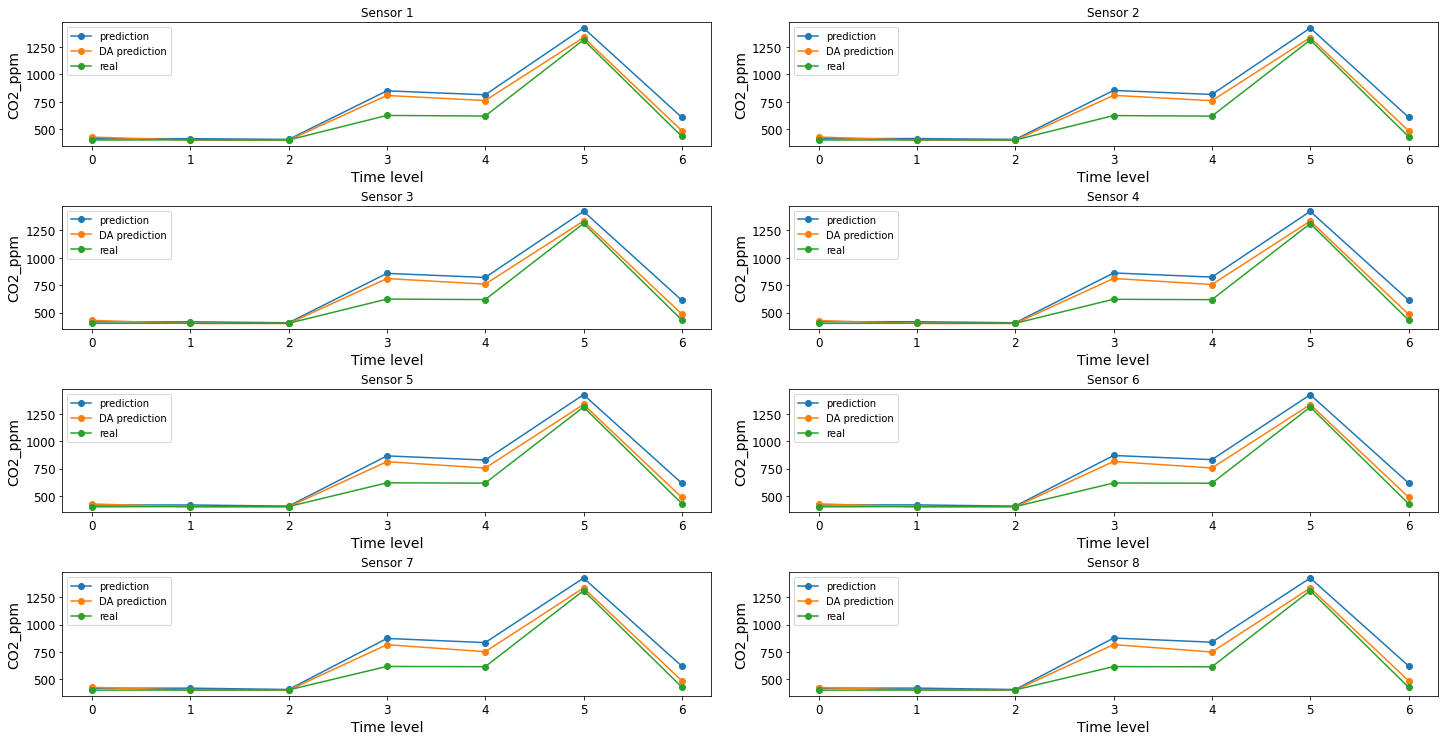

In [ ]:
fig, ax = plt.subplots(4,2, figsize=[20,10])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(8):
    ax.flatten()[i].plot(norm_sensor_CO2_[435+i,:], '-o')
    ax.flatten()[i].plot(norm_sensor_CO2_DA[435+i,:], '-o')
    ax.flatten()[i].plot(sensor_data[435+i,:], '-o')
    ax.flatten()[i].legend(['prediction', 'DA prediction', 'real'])
    ax.flatten()[i].set_title('Sensor '+ str(i+1))
    ax.flatten()[i].set_xlabel('Time level')
    ax.flatten()[i].set_ylabel('CO2_ppm')

# whole prediciton

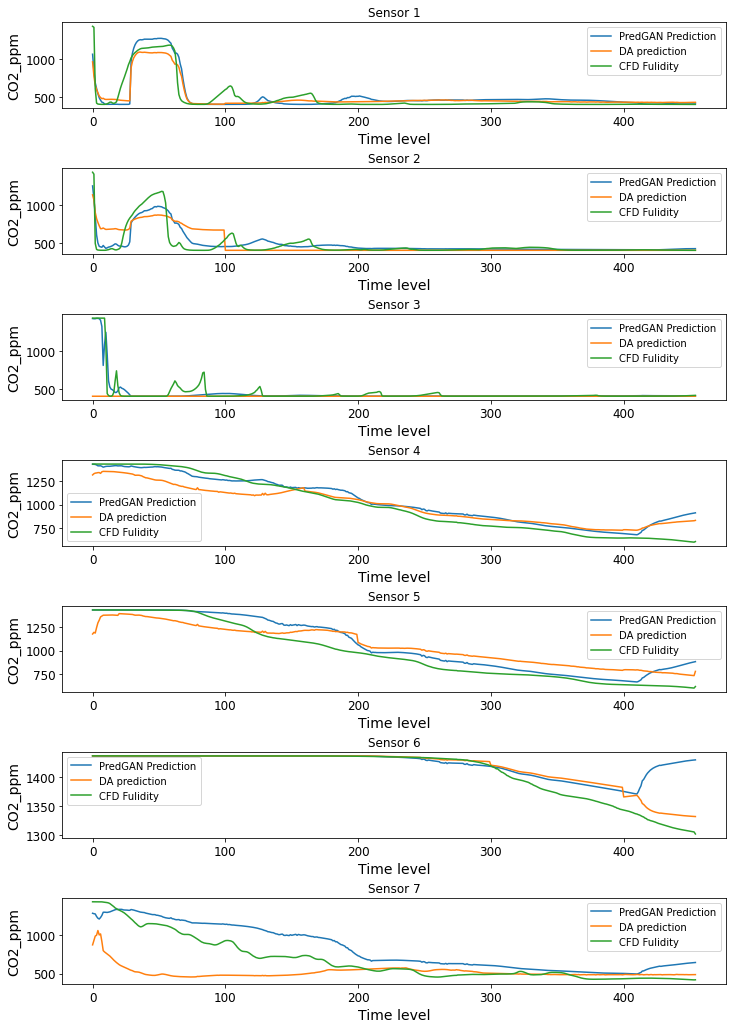

In [ ]:
fig, ax = plt.subplots(7,1, figsize=[10,14])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(7):
  ax.flatten()[i].plot(norm_sensor_CO2_[:,i], '-')
  ax.flatten()[i].plot(norm_sensor_CO2_DA[:,i], '-')
  ax.flatten()[i].plot(sensor_data[:,i], '-')
  ax.flatten()[i].legend(['PredGAN Prediction', 'DA prediction', 'CFD Fulidity'])
  ax.flatten()[i].set_title('Sensor '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('CO2_ppm')

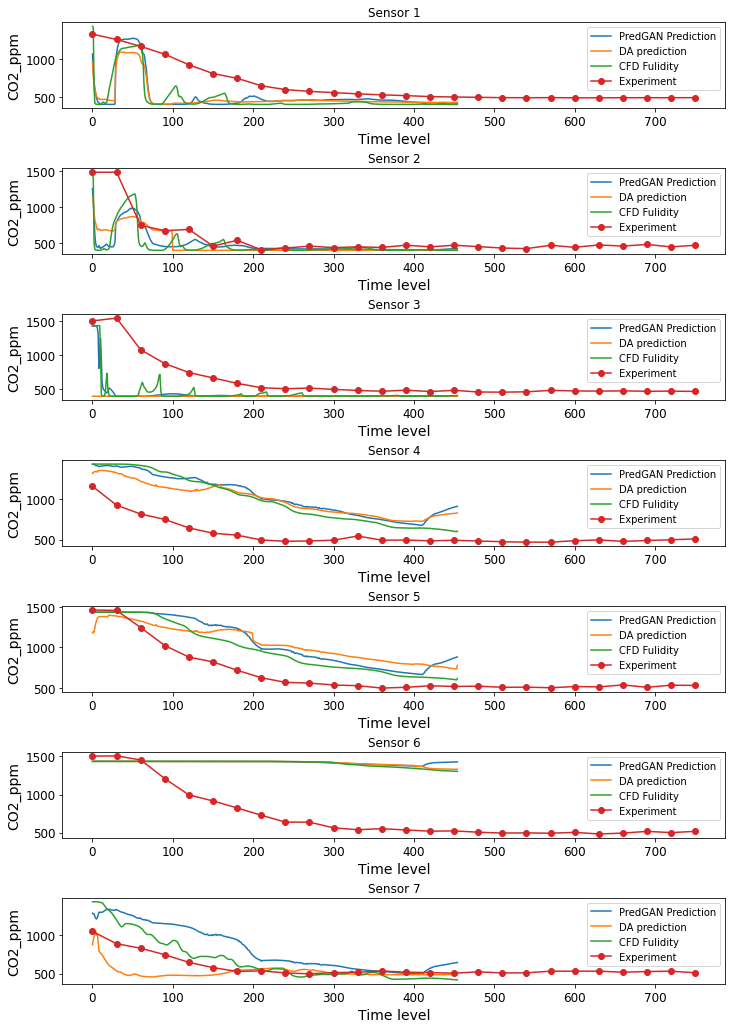

In [ ]:
fig, ax = plt.subplots(7,1, figsize=[10,14])
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(7):
  ax.flatten()[i].plot(norm_sensor_CO2_[:,i], '-')
  ax.flatten()[i].plot(norm_sensor_CO2_DA[:,i], '-')
  ax.flatten()[i].plot(sensor_data[:,i], '-')
  ax.flatten()[i].plot(Exp_time/2, Experiment_data[:,i], '-o')
  ax.flatten()[i].legend(['PredGAN Prediction', 'DA prediction', 'CFD Fulidity', 'Experiment'])
  ax.flatten()[i].set_title('Sensor '+ str(i+1))
  ax.flatten()[i].set_xlabel('Time level')
  ax.flatten()[i].set_ylabel('CO2_ppm')


In [ ]:
# save the data
#norm_sensor_CO2_ = np.savetxt('output_files/norm_sensor_CO2_.csv', norm_sensor_CO2_, delimiter=',')
#norm_sensor_CO2_DA = np.savetxt('output_files/norm_sensor_CO2_DA.csv', norm_sensor_CO2_DA, delimiter=',')
#sensor_data = np.savetxt('output_files/sensor_data.csv', sensor_data, delimiter=',')

In [ ]:
norm_sensor_CO2_ = np.loadtxt('output_files/norm_sensor_CO2_.csv', delimiter=',')
norm_sensor_CO2_DA = np.loadtxt('output_files/norm_sensor_CO2_DA.csv', delimiter=',')
sensor_data = np.loadtxt('output_files/sensor_data.csv', delimiter=',')

In [ ]:
def write_example_to_vtu(exm_num):
  # get clean vtu file
  snapshot_data_location = '/content/gdrive/MyDrive/ACSE-9/ClarenceCentre/run_Clip_ToSend/'
  snapshot_file_base = 'ClarenceCentre_'
  filename = snapshot_data_location + snapshot_file_base + '0.vtu'
  clean_vtu = get_clean_vtu_file(filename)

  # write results to vtu
  nNodes = get_nNodes_from_vtu(snapshot_data_location, snapshot_file_base)
  CO2_ppm = np.zeros((nNodes,1))
  velocity = np.zeros((nNodes,3))
  # sensor_CO2_ppm = np.zeros((7,1)) ## Dont need to add this to VTU

  new_vtu = vtktools.vtu()
  new_vtu.ugrid.DeepCopy(clean_vtu.ugrid)
  new_vtu.filename = '/content/gdrive/MyDrive/ACSE-9/DA-predictions/DA_prediction_' + str(exm_num) + '.vtu'

  CO2_ppm[:] = norm_co2_DA[exm_num].reshape((148906, 1),order='F')
  # for j in range(3):
  velocity[:,0] = norm_x_DA[exm_num].reshape((148906),order='F')
  velocity[:,1] = norm_y_DA[exm_num].reshape((148906),order='F') 
  velocity[:,2] = norm_z_DA[exm_num].reshape((148906),order='F')

  # sensor_CO2_ppm[:] = norm_sensor_CO2_[exm_num].reshape((7, 1), order='F') ## Dont need to add this to VTU


  new_vtu.AddField('CO2_ppm', CO2_ppm)
  new_vtu.AddField('Velocity', velocity)
  #new_vtu.AddField('Sensor_CO2_ppm', sensor_CO2_ppm) ## Dont need to add this field to VTU
  new_vtu.Write()

In [ ]:
# writing to vtu file
tic = time.time()
nVTU = norm_co2_DA.shape[0]
for i in range(nVTU):
  tic = time.time()
  write_example_to_vtu(i)
  toc = time.time()
  print("DA-PredGAN VTU file", i, "written in ", toc - tic, "seconds")
print("completed")

DA-PredGAN VTU file 0 written in  8.66422414779663 seconds
DA-PredGAN VTU file 1 written in  4.720486879348755 seconds
DA-PredGAN VTU file 2 written in  4.8060784339904785 seconds
DA-PredGAN VTU file 3 written in  5.005850553512573 seconds
DA-PredGAN VTU file 4 written in  4.8241071701049805 seconds
DA-PredGAN VTU file 5 written in  5.015798568725586 seconds
DA-PredGAN VTU file 6 written in  4.7982566356658936 seconds
DA-PredGAN VTU file 7 written in  4.725533723831177 seconds
DA-PredGAN VTU file 8 written in  4.746427059173584 seconds
DA-PredGAN VTU file 9 written in  4.791801691055298 seconds
DA-PredGAN VTU file 10 written in  4.995858669281006 seconds
DA-PredGAN VTU file 11 written in  4.813577175140381 seconds
DA-PredGAN VTU file 12 written in  4.959164619445801 seconds
DA-PredGAN VTU file 13 written in  4.766206741333008 seconds
DA-PredGAN VTU file 14 written in  4.9351794719696045 seconds
DA-PredGAN VTU file 15 written in  4.89423394203186 seconds
DA-PredGAN VTU file 16 written i